In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
############## sys imports #############
import os
import sys
import time
import copy
import argparse
import datetime
############## basic stats imports #############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
############## pytorch imports #############
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader

In [3]:
############## custom imports #############
from dataloader import FaceScrubDataset, TripletFaceScrub, SiameseFaceScrub
from dataloader import FaceScrubBalancedBatchSampler

from networks import *
from losses import OnlineTripletLoss
from openface.loadOpenFace import prepareOpenFace
from utils import save_checkpoint, save_hyperparams, AverageMeter, HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector

In [4]:
# DATA_PATH = '/home/s1791387/facescrub-data/new_data_max/'
DATA_PATH = '/home/var/final-fs-data/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train_full_with_ids.txt')
VALID_PATH = os.path.join(DATA_PATH, 'val_full_with_ids.txt')
TEST_PATH = os.path.join(DATA_PATH, 'test_full_with_ids.txt')
# WEIGHTS_PATH = '/home/s1791387/facescrub-data/new_data_max/openface_model_weigths/job_semi_std_cos3_Jul_25_1000hrs/weights_75.pth'

In [5]:
batch_size = 512
input_size = 96
output_dim = 128
learning_rate = 1e-3
num_epochs = 10
start_epoch = 0

triplet_margin = 1.  # margin
triplet_p = 2  # norm degree for distance calculation

resume_training = False
workers = 4
use_cuda = True

In [6]:
cuda = False
pin_memory = False
if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))
print('Training set path: {}'.format(TRAIN_PATH))
print('Training set Path exists: {}'.format(os.path.isfile(TRAIN_PATH)))

Device set: cuda
Training set path: /home/var/final-fs-data/train_full_with_ids.txt
Training set Path exists: True


In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}


train_df = FaceScrubDataset(
    txt_file=TRAIN_PATH, root_dir=DATA_PATH, transform=data_transforms['val'])

val_df = FaceScrubDataset(
    txt_file=VALID_PATH, root_dir=DATA_PATH, transform=data_transforms['val'])

# siamese_train_df = SiameseFaceScrub(train_df, train=True)
# print('Train data converted to siamese form. Length: {}'.format(len(siamese_train_df)))

# siamese_val_df=SiameseFaceScrub(val_df, train=False)
# print('Validation data converted to siamese form. Length: {}'.format(
#     len(siamese_val_df)))

train_loader=torch.utils.data.DataLoader(
        train_df, batch_size=batch_size, shuffle=True, pin_memory=pin_memory, num_workers=workers)
print('Train loader created. Length of train loader: {}'.format(
        len(train_loader)))
    
val_loader=torch.utils.data.DataLoader(
        val_df, batch_size=batch_size, shuffle=False, pin_memory=pin_memory, num_workers=workers)
print('Val loader created. Length of train loader: {}'.format(
        len(val_loader)))



Train loader created. Length of train loader: 109
Val loader created. Length of train loader: 12


In [8]:
openface = prepareOpenFace(useCuda=cuda)
params = sum(p.numel() for p in openface.parameters() if p.requires_grad)
print('Number of params in network {}'.format(params))

# en_optimizer=optim.Adam(openface.parameters(), lr=learning_rate)

Sent model to GPU
Number of params in network 3733968


In [9]:
if resume_training:
    resume_weights=WEIGHTS_PATH
    if cuda:
        checkpoint=torch.load(resume_weights)
    else:
        # Load GPU model on CPU
        checkpoint=torch.load(resume_weights,
                                map_location=lambda storage,
                                loc: storage)

    start_epoch=checkpoint['epoch']
    openface.load_state_dict(checkpoint['state_dict'])
    en_optimizer.load_state_dict(checkpoint['optimizer'])
    best_loss = checkpoint['best_loss']
    # scheduler.load_state_dict(checkpoint['scheduler'])
    print("=> loaded checkpoint '{}' (trained for {} epochs)".format(
        resume_weights, checkpoint['epoch']))
#     for epoch in range(0, start_epoch):
#         en_scheduler.step()

In [10]:
if cuda:
    openface.cuda()
#     classifier.cuda()
    print('Sent model to gpu {}'.format(
        next(openface.parameters()).is_cuda))

Sent model to gpu True


In [26]:
reps = pd.read_csv('reps_new8.csv', index_col=0)
y = pd.read_csv('names_num8.csv', index_col=0, names=['name'], skiprows=1)
s = pd.read_csv('gender_num8.csv', index_col=0)

In [33]:
y.name == 1

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
        ...  
1417    False
1418    False
1419    False
1420    False
1421    False
1422    False
1423    False
1424    False
1425    False
1426    False
1427    False
1428    False
1429    False
1430    False
1431    False
1432    False
1433    False
1434    False
1435    False
1436    False
1437    False
1438    False
1439    False
1440    False
1441    False
1442    False
1443    False
1444    False
1445    False
1446    False
Name: name, Length: 1447, dtype: bool

In [39]:
import random
random.seed(1791387)

for name in y.name.unique():
    (y == name)

In [127]:
import matplotlib.cm as cm
plt.style.use('bmh')

In [128]:
colors = cm.Dark2(np.linspace(0, 1, len(select_names)))

In [129]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [130]:
X_pca = PCA(n_components=50).fit_transform(X, X)
tsne = TSNE(n_components=2, init='random', random_state=0)
X_r = tsne.fit_transform(X_pca)

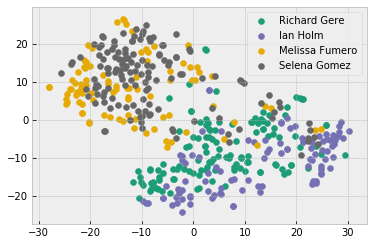

In [154]:
for c, i, target_name in zip(colors,
                             list(range(1, len(select_names) + 1)),
                             select_names):
    plt.scatter(X_r[(y == i)[0], 0], X_r[(y == i)[0], 1],
                c=c, label=target_name)
plt.legend()
plt.show()

In [155]:
out = "tsne.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: tsne.pdf


<Figure size 432x288 with 0 Axes>